# Modelo lineal del artículo con variables instrumentales - Agentes libres

En este modelo que es de la siguiente forma:

necesitaremos la base de datos que contruimos con toda la información relevante de los equipos!

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import array
import math
import os
import warnings
print('Modulos importados')

Modulos importados


In [2]:
# Configuraciones
warnings.filterwarnings('ignore')
# Reduzcamos el número de línea a leer
pd.options.display.max_rows = 15

In [3]:
# Veamos el directorio actual de trabajo
print(os.getcwd())
# El directorio anterior es el correcto, pero si no lo fuese, hacemos lo sigueinte:
path = '/home/usuario/Documentos/Github/Proyectos/MLB_HN'
os.chdir(path)

/home/usuario/Documentos/Github/Proyectos/MLB_HN/Models/Instrumental_variables/Free_agent


In [4]:
print("Para modificar el tamaño de todos los gráficos")
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,9

Para modificar el tamaño de todos los gráficos


Leamos los archivos correspondientes

In [5]:
# Años de análisis
period = 11
csv = '.csv'
# Directorios
names_path = 'Data/Teams/team_acronym'
state_path = 'Data/Teams/team_states'
teams_path = 'Data/New_Data/Teams/free_agents_team_'
victories_path = 'Data/Teams/team_victories_'
batters_path = 'Data/New_Data/Hitters/Free_Agent/free_agents_batters_'
pitchers_path = 'Data/New_Data/Pitchers/Free_Agent/free_agents_pitchers_'
# Originales:
df_team = [None]*period
df_team_copy = [None]*period
df_batters = [None]*period
df_batters_copy = [None]*period
df_pitchers = [None]*period
df_pitchers_copy = [None]*period
df_players = [None]*period
df_players_copy = [None]*period
df_victories = [None]*period
df_victories_copy = [None]*period

Leamos todos las bases de datos correspondientes

In [6]:
names = pd.read_csv(names_path + csv)
states = pd.read_csv(state_path + csv)
states_copy = states.copy()
for year in range(0,period):
    df_batters[year] = pd.read_csv(batters_path + str(2011 + year) + csv)
    df_batters_copy[year] = df_batters[year].copy()
    
    df_pitchers[year] = pd.read_csv(pitchers_path + str(2011 + year) + csv)
    df_pitchers_copy[year] = df_pitchers[year].copy()
    
    df_team[year] = pd.read_csv(teams_path + str(2011 + year) + csv)
    df_team_copy[year] = df_team[year].copy()
    
    df_victories[year] = pd.read_csv(victories_path + str(2011 + year) + csv)
    df_victories_copy[year] = df_victories[year].copy()

Observemos el contenido de las bases de datos

In [7]:
# Cantidad de equipos por estado
states.head()

,Estado,Cantidad de equipos
0,Alabama,0
1,Alaska,0
2,Arizona,1
3,Arkansas,0
4,California,5


In [8]:
# Nombres de todos los equipos en todss las bases de datos
names.head()

,Equipo,Acronimo,Estado
0,Arizona Diamondbacks,ARI,Arizona
1,Atlanta Braves,ATL,Georgia
2,Baltimore Orioles,BAL,Maryland
3,Boston Red Sox,BOS,Massachusetts
4,Chicago Cubs,CHC,Illinois


In [9]:
# Equipos
df_team_copy[1].head()

,Equipo,Cantidad_agentes_libres,Valor_contrato,Acronimo,Victorias,Juegos totales,Promedio_victorias
0,Los Angeles Angels,4,321150000,LAA,89,162,0.549383
1,Detroit Tigers,3,221000000,DET,88,162,0.543210
2,Miami Marlins,6,203300000,MIA,69,162,0.425926
3,Philadelphia Phillies,7,57650000,PHI,81,162,0.500000
4,Los Angeles Dodgers,9,44651311,LAD,86,162,0.530864


In [10]:
# Bateadores
df_batters_copy[1].head()

,Jugador,Valor_contrato,Valor_promedio_contrato,Posicion,Juegos,Porcetnaje_juegos,At-bats,Bateos,Home-runs,RBI,Porcentaje_bateo,OPS,Equipo,Sueldo
0,Albert Pujols,240000000,24000000,DH,154,0.951,607,173,30,105,0.285,0.859,LAA,12000000
1,Prince Fielder,214000000,23777778,DH,162,1.000,581,182,30,108,0.313,0.940,DET,23150000
2,Jose Reyes,106000000,17666667,3B,160,0.988,642,184,11,57,0.287,0.780,MIA,10000000
3,C.J. Wilson,77500000,15500000,SP,34,0.210,5,0,0,0,0.000,0.167,LAA,10550000
4,Mark Buehrle,58000000,14500000,SP,31,0.191,67,3,0,1,0.045,0.104,MIA,7000000


In [11]:
# PItchers
df_pitchers_copy[1].head()

,Jugador,Valor_contrato,Valor_promedio_contrato,Posicion,Juegos,Juegos_iniciados,Inning_pitched,Bateos_pitcher,Carreras,Carreras_ganadas,Walks,Strike-outs,Wins,Losses,Saves,WHIP,ERA,Equipo,Sueldo
0,C.J. Wilson,77500000,15500000,SP,34,34,202.3,181,102,86,91,173,13,10,0,1.34,3.83,LAA,10550000
1,Mark Buehrle,58000000,14500000,SP,31,31,202.3,197,88,84,40,125,13,13,0,1.17,3.74,MIA,7000000
2,Jonathan Papelbon,50000000,12500000,RP,70,0,70.0,56,22,19,18,92,5,6,38,1.06,2.44,PHI,11000058
3,Heath Bell,27000000,9000000,RP,73,0,63.7,70,38,36,29,59,4,5,19,1.55,5.09,MIA,7000000
4,Joe Nathan,14000000,7000000,RP,66,0,64.3,55,23,20,13,78,3,5,37,1.06,2.80,TEX,8050000


In [12]:
# Victorias
df_victories_copy[1].head()

,Acronimo,Equipo,Victorias,Juegos totales,Playoffs,Pennants won,WS ganadas
0,ARI,Arizona Diamondbacks,81,162,5,1,1
1,ATL,Atlanta Braves,94,162,22,18,3
2,BAL,Baltimore Orioles,93,162,12,7,3
3,BOS,Boston Red Sox,69,162,20,12,7
4,CHC,Chicago Cubs,61,162,16,17,2


### Construcción de la base de datos para el modelo

#### Base de datos de los equipos

Primero, tenemos que determinar cuál es el mínimo y máximo del promedio de victorias de cada equipo a lo largo del periodo de análisis. Primero, creemos un diccionario que guarde en una lista ambos valores cuya llave asociada sea el nombre del equipo. Se tomará el promedio y no el número de victorias puesto que no todos los equipos juegan la misma cantidad de partidos en una temporada y habría fallos en el análisis en años como el 2020 por la pandemia que provocó que la cantidad de juegos por temporada fuiera mucho menor  a la usual, siendo alrededor de 60 juegos en dicha temporada.

Para crear este diccionario usaremos la base de datos de los acrónimos puesto que contiene todos los equipos que puedan haber en las bases de datos de los equipos en el periodo de análisis

In [13]:
minmax_victories = {}
length_names = len(names['Equipo'])
# CReemos las llaves con los nombres de los equipos
for i in range(0,length_names):
    minmax_victories[str(names['Equipo'].iloc[i])] = [None]*2

Como valores de comparación para las victorias usaremos cualquier base de datos que contenga la misma cantidad de filas que la base de datos *names*. Obtengamos el índice de las bases de datos que cumplan esa condición.

In [14]:
for year in range(0,period):
    if len(df_team_copy[year]['Equipo']) == length_names:
        print(year)

2
3
4
5
6
8
10


In [15]:
# Usaremos la tercera base de datos
team_name = list(minmax_victories.keys())
for i in range(length_names):
    for j in range(length_names):
        if team_name[i] == df_team_copy[2]['Equipo'].iloc[j]:
            minmax_victories[team_name[i]][0] = df_team_copy[2]['Promedio_victorias'].iloc[j]
            minmax_victories[team_name[i]][1] = df_team_copy[2]['Promedio_victorias'].iloc[j]

Ahora, recorreremos el promedio de victorias de todas las bases de datos para hallar el menor y mayor número de victorias que ha tenido cada equipo en el periodo de análisis.

In [16]:
for year in range(period):
    # Nombres de los equipos en la base de datos
    team_year_name = list(df_team_copy[year]['Equipo'])
    
    for i in range(length_names):
        # Mínimo actual
        min_victory = minmax_victories[team_name[i]][0]
        # Máximo actual:
        max_victory = minmax_victories[team_name[i]][1]
        
        for j in range(len(team_year_name)):
            
            if team_name[i] == team_year_name[j]:
                year_victory = df_team_copy[year]['Promedio_victorias'].iloc[j]
                
                # Mínimo nuevo:
                if year_victory < min_victory:
                    minmax_victories[team_name[i]][0] = year_victory
                # Máximo nuevo:
                elif year_victory > max_victory:
                    minmax_victories[team_name[i]][1] = year_victory

Los valores de la lista ahora son de la siguiente forma:

In [17]:
print(minmax_victories[team_name[1]])

[0.40625, 0.6024844720496895]


A continuación, se creará una columna que indique si la victoria de la temporada -correspondiente a la base de datos donde se situe- está más cercana del promedio más alto de victorias o del menor. 1 indicará que está más cercano a la mayor victoria, y 0 en otro caso -en caso de empate, se eligirá al 1.

In [18]:
for year in range(period):
    # Nombres de los equipos en la base de datos
    team_year_name = list(df_team_copy[year]['Equipo'])
    # COlumna dummy:
    df_team_copy[year]['I_t'] = -1
    
    for i in range(length_names):
        # Mínimo actual
        min_victory = minmax_victories[team_name[i]][0]
        # Máximo actual:
        max_victory = minmax_victories[team_name[i]][1]
        
        for j in range(len(team_year_name)):
            
            if team_name[i] == team_year_name[j]:
                year_victory = df_team_copy[year]['Promedio_victorias'].iloc[j]
                
                # Distancia al mínimo:
                dist_min = year_victory - min_victory
                # Distancia al máximo:
                dist_max = max_victory - year_victory
                
                # Mínimo nuevo:
                if dist_min < dist_max:
                    df_team_copy[year]['I_t'].iloc[j] = 1
                # Máximo nuevo
                else:  
                    df_team_copy[year]['I_t'].iloc[j] = 0

In [19]:
df_team_copy[6].tail()

,Equipo,Cantidad_agentes_libres,Valor_contrato,Acronimo,Victorias,Juegos totales,Promedio_victorias,I_t
24,Milwaukee Brewers,3,7550000,MIL,86,162,0.530864,0
25,Chicago White Sox,1,6000000,CHW,67,162,0.413580,1
26,Boston Red Sox,1,5500000,BOS,93,162,0.574074,0
27,Cincinnati Reds,2,5300000,CIN,68,162,0.419753,1
28,Detroit Tigers,1,2000000,DET,64,162,0.395062,1


Usemos la variable dummy para crear la columna que contenga el siguiente dato:

$$
X = \left( -1 \right)^{I_{t}^{-}}\frac{y_{t}}{\sqrt{y_H}}
$$

In [20]:
for year in range(period):
    # Nombres de los equipos en la base de datos
    team_year_name = list(df_team_copy[year]['Equipo'])
    # Columna de la nueva variable
    df_team_copy[year]['X'] = -1
    
    for i in range(length_names):        
        for j in range(len(team_year_name)):
            
            if team_name[i] == team_year_name[j]:
                # Variables auxiliares
                mean_victory = df_team_copy[year]['Promedio_victorias'].iloc[j]
                dummy = df_team_copy[year]['I_t'].iloc[j]
                s_max_victory = np.power(minmax_victories[team_name[i]][1],0.5)
                if dummy == 0:
                    parity = 1
                else:
                    parity = -1
                
                # Variable dummy nueva
                df_team_copy[year]['X'].iloc[j] = parity*mean_victory/s_max_victory

In [21]:
df_team_copy[1].tail()

,Equipo,Cantidad_agentes_libres,Valor_contrato,Acronimo,Victorias,Juegos totales,Promedio_victorias,I_t,X
21,Kansas City Royals,2,5000000,KC,72,162,0.444444,1,-0.581656
22,San Francisco Giants,3,4800000,SF,94,162,0.580247,0,0.712844
23,Atlanta Braves,1,1000000,ATL,94,162,0.580247,0,0.747549
24,Chicago White Sox,1,900000,CHW,85,162,0.524691,0,0.686982
25,Houston Astros,1,750000,HOU,55,162,0.339506,1,-0.418415


In [22]:
df_team_copy[1].tail()

,Equipo,Cantidad_agentes_libres,Valor_contrato,Acronimo,Victorias,Juegos totales,Promedio_victorias,I_t,X
21,Kansas City Royals,2,5000000,KC,72,162,0.444444,1,-0.581656
22,San Francisco Giants,3,4800000,SF,94,162,0.580247,0,0.712844
23,Atlanta Braves,1,1000000,ATL,94,162,0.580247,0,0.747549
24,Chicago White Sox,1,900000,CHW,85,162,0.524691,0,0.686982
25,Houston Astros,1,750000,HOU,55,162,0.339506,1,-0.418415


Por último, solo nos quedaremos con las columnas de utilidad que son el acrónimo del equipo y la variable $X$.

In [23]:
for year in range(0,period):
    df_team_copy[year] = df_team_copy[year][["Acronimo", "X"]]

In [24]:
df_team_copy[1].head()

,Acronimo,X
0,LAA,0.704166
1,DET,0.716941
2,MIA,-0.592555
3,PHI,0.702782
4,LAD,-0.629194


### Equipos por estado

Agregaremos la cantidad de equipos por esado como una variable de control, le haremos merge al dataframe obtenido arriba. Sin embargo, para esto, usemos la base de datos de los nombres.

In [25]:
states_copy = pd.merge(states_copy, names, on = 'Estado')

In [26]:
states_copy = states_copy[['Acronimo', 'Cantidad de equipos']]
states_copy.head()

,Acronimo,Cantidad de equipos
0,ARI,1
1,LAA,5
2,LAD,5
3,OAK,5
4,SD,5


Para este apartado solo falta hacer el *merge* con las bases de datos correspondientes

In [27]:
for year in range(0, period):
    df_team_copy[year] = pd.merge(df_team_copy[year], states_copy, on = 'Acronimo')
    
    df_team_copy[year].columns = ['Acronimo', 'X', 'Equipos por estado']

In [28]:
df_team_copy[1].head()

,Acronimo,X,Equipos por estado
0,LAA,0.704166,5
1,DET,0.716941,1
2,MIA,-0.592555,2
3,PHI,0.702782,2
4,LAD,-0.629194,5


## Victories en playoffs y series mundiales

El procedimiento es totalmente análogo al anterior. No obstante, miremos qué columnas contienen

In [29]:
df_victories_copy[1].head()

,Acronimo,Equipo,Victorias,Juegos totales,Playoffs,Pennants won,WS ganadas
0,ARI,Arizona Diamondbacks,81,162,5,1,1
1,ATL,Atlanta Braves,94,162,22,18,3
2,BAL,Baltimore Orioles,93,162,12,7,3
3,BOS,Boston Red Sox,69,162,20,12,7
4,CHC,Chicago Cubs,61,162,16,17,2


Haremos el merge con *df_teams_copy* por medio del acrónimo del equipo

In [30]:
for year in range(0, period):
    df_team_copy[year] = pd.merge(df_team_copy[year], df_victories_copy[year], on = 'Acronimo')

In [31]:
df_team_copy[1].head()

,Acronimo,X,Equipos por estado,Equipo,Victorias,Juegos totales,Playoffs,Pennants won,WS ganadas
0,LAA,0.704166,5,Los Angeles Angels,89,162,10,1,1
1,DET,0.716941,1,Detroit Tigers,88,162,14,11,4
2,MIA,-0.592555,2,Miami Marlins,69,162,2,2,2
3,PHI,0.702782,2,Philadelphia Phillies,81,162,14,7,2
4,LAD,-0.629194,5,Los Angeles Dodgers,86,162,26,25,6


In [32]:
for year in range(0, period):
    df_team_copy[year] = df_team_copy[year][['Acronimo', 'X', 'Equipos por estado',
                                             'Playoffs', 'Pennants won', 'WS ganadas']]
    
    df_team_copy[year].columns = ['Acronimo', 'X', 'Equipos por estado',
                                  'Playoffs', 'Pennants ganados', 'WS ganadas']

In [33]:
df_team_copy[1].head()

,Acronimo,X,Equipos por estado,Playoffs,Pennants ganados,WS ganadas
0,LAA,0.704166,5,10,1,1
1,DET,0.716941,1,14,11,4
2,MIA,-0.592555,2,2,2,2
3,PHI,0.702782,2,14,7,2
4,LAD,-0.629194,5,26,25,6


### Batters

Preparemos las bases de datos de los *batters*.

Por otro lado, tenemos que traer los valores de los salarios -en dolares- a valor presente, del 2021, ajustado por la inflación. Usaremos la página [CPI Inflation Calculator](https://www.in2013dollars.com/)

Guardaremos los porcentajes de cambio de cada año en un diccionario, de paso, cambiaremos el nombre de la columna *Equipo* por *Acrónimo*.

In [34]:
change_inflation_percentage = {2011:20.46, 2012:18.02, 2013:16.32, 2014:14.46, 2015:14.33, 2016:12.90, 2017:10.55, 2018:7.86, 2019:5.99, 2020:4.70, 2021:1}

In [35]:
for year in range(0,period):
    df_batters_copy[year][["Salario_ajustado_2021"]] = df_batters_copy[year][["Sueldo"]]*(1 + change_inflation_percentage[2011 + year]*0.01)
    df_batters_copy[year].rename(columns = {'Equipo':'Acronimo'}, inplace = True)

In [36]:
df_batters_copy[1].head()

,Jugador,Valor_contrato,Valor_promedio_contrato,Posicion,Juegos,Porcetnaje_juegos,At-bats,Bateos,Home-runs,RBI,Porcentaje_bateo,OPS,Acronimo,Sueldo,Salario_ajustado_2021
0,Albert Pujols,240000000,24000000,DH,154,0.951,607,173,30,105,0.285,0.859,LAA,12000000,14162400.0
1,Prince Fielder,214000000,23777778,DH,162,1.000,581,182,30,108,0.313,0.940,DET,23150000,27321630.0
2,Jose Reyes,106000000,17666667,3B,160,0.988,642,184,11,57,0.287,0.780,MIA,10000000,11802000.0
3,C.J. Wilson,77500000,15500000,SP,34,0.210,5,0,0,0,0.000,0.167,LAA,10550000,12451110.0
4,Mark Buehrle,58000000,14500000,SP,31,0.191,67,3,0,1,0.045,0.104,MIA,7000000,8261400.0


Lo que se tiene que hacer a continuación es añadir la variable $X$ a la base de datos anterior, esto se tiene que hacer de acuerdo al equipo

In [37]:
for year in range(0,period):
    df_batters_copy[year] = pd.merge(df_batters_copy[year], df_team_copy[year], on = 'Acronimo')

In [38]:
df_batters_copy[1].head()

,Jugador,Valor_contrato,Valor_promedio_contrato,Posicion,Juegos,Porcetnaje_juegos,At-bats,Bateos,Home-runs,RBI,Porcentaje_bateo,OPS,Acronimo,Sueldo,Salario_ajustado_2021,X,Equipos por estado,Playoffs,Pennants ganados,WS ganadas
0,Albert Pujols,240000000,24000000,DH,154,0.951,607,173,30,105,0.285,0.859,LAA,12000000,1.416240e+07,0.704166,5,10,1,1
1,C.J. Wilson,77500000,15500000,SP,34,0.210,5,0,0,0,0.000,0.167,LAA,10550000,1.245111e+07,0.704166,5,10,1,1
2,Bobby Abreu,401311,401311,LF,200,0.617,438,106,6,48,0.242,0.693,LAA,8598689,1.014817e+07,0.704166,5,10,1,1
3,Prince Fielder,214000000,23777778,DH,162,1.000,581,182,30,108,0.313,0.940,DET,23150000,2.732163e+07,0.716941,1,14,11,4
4,Omar Infante,8000000,4000000,2B,149,0.920,554,152,12,53,0.274,0.719,DET,2142076,2.528078e+06,0.716941,1,14,11,4


Solo interesan las columnas que contienen el nombre del jugador, su salario ajustado y la variable $X$ (también las de control de la base de datos de victorias).

$$
X = \left( -1 \right)^{I_{t}^{-}}\frac{y_{t}}{\sqrt{y_H}}
$$

In [39]:
for year in range(0,period):
    df_batters_copy[year] = df_batters_copy[year][["Jugador", "Salario_ajustado_2021", "X", 
                                                   "Posicion", "Acronimo", "Equipos por estado", 
                                                   "Playoffs", "Pennants ganados", "WS ganadas"]]

In [40]:
df_batters_copy[1].head()

,Jugador,Salario_ajustado_2021,X,Posicion,Acronimo,Equipos por estado,Playoffs,Pennants ganados,WS ganadas
0,Albert Pujols,1.416240e+07,0.704166,DH,LAA,5,10,1,1
1,C.J. Wilson,1.245111e+07,0.704166,SP,LAA,5,10,1,1
2,Bobby Abreu,1.014817e+07,0.704166,LF,LAA,5,10,1,1
3,Prince Fielder,2.732163e+07,0.716941,DH,DET,1,14,11,4
4,Omar Infante,2.528078e+06,0.716941,2B,DET,1,14,11,4


### Pitchers

Repetiremos el mismo proceso que con las bases de datos de los *batters*

In [41]:
for year in range(0,period):
    df_pitchers_copy[year][["Salario_ajustado_2021"]] = df_pitchers_copy[year][["Sueldo"]]*(1 + change_inflation_percentage[2011 + year]*0.01)
    df_pitchers_copy[year].rename(columns = {'Equipo':'Acronimo'}, inplace = True)
    
    df_pitchers_copy[year] = pd.merge(df_pitchers_copy[year], df_team_copy[year], on = 'Acronimo')
    
    df_pitchers_copy[year] = df_pitchers_copy[year][["Jugador", "Salario_ajustado_2021", "X",
                                                     "Posicion", "Acronimo", "Equipos por estado", 
                                                     "Playoffs", "Pennants ganados", "WS ganadas"]]

In [42]:
df_pitchers_copy[1].head()

,Jugador,Salario_ajustado_2021,X,Posicion,Acronimo,Equipos por estado,Playoffs,Pennants ganados,WS ganadas
0,C.J. Wilson,1.245111e+07,0.704166,SP,LAA,5,10,1,1
1,LaTroy Hawkins,3.540600e+06,0.704166,RP/CL,LAA,5,10,1,1
2,Mark Buehrle,8.261400e+06,-0.592555,SP,MIA,2,2,2,2
3,Heath Bell,8.261400e+06,-0.592555,RP,MIA,2,2,2,2
4,Jonathan Papelbon,1.298227e+07,0.702782,RP,PHI,2,14,7,2


### Players

Debido a que hay agentes libres que son tanto *batters* como *pitchers*, haremos el merge por año.

Sin embargo, primero tenemos que obtener como referencia el número de jugadores que tendrá dicho dataframe; esto, para evitar errores. Para ello, necesitamos obtener los nombres de cada base de datos por año y unirlos ya sea eliminando duplicados o con otro método. Finalmente, se imprimirá la longitud **mínima** de dicha lista. Se dice mínima puesto que aquí no estamos haciendo distinción por caracetrísticas ajenas al nombre.

In [43]:
for year in range(0,period):
    print("Año: " + str(2011 + year))
    print("Número de nombres únicos en batters: ")
    batters_names = np.unique(df_batters_copy[year]["Jugador"].tolist())
    print(len(batters_names))
    
    print("Número de nombres únicos en pitchers: ")
    pitchers_names = np.unique(df_pitchers_copy[year]["Jugador"].tolist())
    print(len(pitchers_names))
    
    print("Número de nombres únicos en el merge:")
    merge_players = np.unique(batters_names.tolist() + pitchers_names.tolist())
    print(len(merge_players))
    print()

Año: 2011
Número de nombres únicos en batters: 
1
Número de nombres únicos en pitchers: 
0
Número de nombres únicos en el merge:
1

Año: 2012
Número de nombres únicos en batters: 
45
Número de nombres únicos en pitchers: 
18
Número de nombres únicos en el merge:
52

Año: 2013
Número de nombres únicos en batters: 
78
Número de nombres únicos en pitchers: 
51
Número de nombres únicos en el merge:
101

Año: 2014
Número de nombres únicos en batters: 
89
Número de nombres únicos en pitchers: 
67
Número de nombres únicos en el merge:
122

Año: 2015
Número de nombres únicos en batters: 
76
Número de nombres únicos en pitchers: 
68
Número de nombres únicos en el merge:
110

Año: 2016
Número de nombres únicos en batters: 
101
Número de nombres únicos en pitchers: 
72
Número de nombres únicos en el merge:
130

Año: 2017
Número de nombres únicos en batters: 
64
Número de nombres únicos en pitchers: 
41
Número de nombres únicos en el merge:
80

Año: 2018
Número de nombres únicos en batters: 
58
Nú

Para facilitar el merge de las bases de datos eliminaremos los registros repetidos. Esto tiene como objetivo usar el método concat para evitarnos problemas de duplicados de columnas

In [44]:
for year in range(0,period):
    batters_names = np.unique(df_batters_copy[year]["Jugador"].tolist())
    pitchers_names = np.unique(df_pitchers_copy[year]["Jugador"].tolist())
    
    df_players_copy[year] = pd.concat([df_batters_copy[year], df_pitchers_copy[year]]).drop_duplicates().reset_index(drop=True)
    print("Año " + str(2011 + year) + ":")
    print(str(len(df_players_copy[year]["Jugador"])) + "\n")

Año 2011:
1

Año 2012:
56

Año 2013:
101

Año 2014:
125

Año 2015:
114

Año 2016:
133

Año 2017:
80

Año 2018:
86

Año 2019:
87

Año 2020:
101

Año 2021:
105



In [45]:
df_players_copy[1].head()

,Jugador,Salario_ajustado_2021,X,Posicion,Acronimo,Equipos por estado,Playoffs,Pennants ganados,WS ganadas
0,Albert Pujols,1.416240e+07,0.704166,DH,LAA,5,10,1,1
1,C.J. Wilson,1.245111e+07,0.704166,SP,LAA,5,10,1,1
2,Bobby Abreu,1.014817e+07,0.704166,LF,LAA,5,10,1,1
3,Prince Fielder,2.732163e+07,0.716941,DH,DET,1,14,11,4
4,Omar Infante,2.528078e+06,0.716941,2B,DET,1,14,11,4


Cuando hagamos el merge, tendremos que eliminar los duplicados restantes que no se pudieron hacer enlos dos códigos anteriores debido al hecho de que solo eliminamos duplicados exactos, pero ahora lo haremos específicamente con los nombres.

In [46]:
panel_data = pd.merge(df_players_copy[0], df_players_copy[1], how = 'outer', on = 'Jugador')

for year in range(2,period):
    panel_data = pd.merge(panel_data, df_players_copy[year], how = 'outer', on = 'Jugador')

panel_data.drop_duplicates(subset = 'Jugador', inplace = True)

In [47]:
panel_data.head()

,Jugador,Salario_ajustado_2021_x,X_x,Posicion_x,Acronimo_x,Equipos por estado_x,Playoffs_x,Pennants ganados_x,WS ganadas_x,Salario_ajustado_2021_y,...,Pennants ganados_y,WS ganadas_y,Salario_ajustado_2021,X,Posicion,Acronimo,Equipos por estado,Playoffs,Pennants ganados,WS ganadas
0,Wil Nieves,933565.0,0.7698,C,MIL,1.0,4.0,1.0,0.0,9.441600e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albert Pujols,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.416240e+07,...,NaN,NaN,576205.0,0.775519,DH,LAD,5.0,35.0,25.0,7.0
2,C.J. Wilson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.245111e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bobby Abreu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.014817e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Prince Fielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.732163e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
panel_data.tail()

,Jugador,Salario_ajustado_2021_x,X_x,Posicion_x,Acronimo_x,Equipos por estado_x,Playoffs_x,Pennants ganados_x,WS ganadas_x,Salario_ajustado_2021_y,...,Pennants ganados_y,WS ganadas_y,Salario_ajustado_2021,X,Posicion,Acronimo,Equipos por estado,Playoffs,Pennants ganados,WS ganadas
864,Alex Colome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5050000.0,-0.567195,RP,MIN,1.0,17.0,6.0,3.0
865,Anthony Bass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1010000.0,-0.575380,RP,MIA,2.0,3.0,2.0,2.0
866,Andrew Chafin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2777500.0,0.685343,RP,OAK,5.0,29.0,15.0,9.0
867,Keone Kela,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1212000.0,-0.617853,RP,SD,5.0,6.0,2.0,0.0
868,Chris Devenski,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1010000.0,-0.429145,RP,ARI,1.0,6.0,1.0,1.0


In [49]:
panel_data.shape

(609, 89)

Se aprecia que necesitamos reiniciar el índice, pero primero lo ordenaremos alfabéticamente por motivos de *buenas prácticas*.

In [50]:
panel_data = panel_data.sort_values(by = 'Jugador', ascending = True)

In [51]:
panel_data.reset_index(drop = True, inplace = True)
panel_data.head()

,Jugador,Salario_ajustado_2021_x,X_x,Posicion_x,Acronimo_x,Equipos por estado_x,Playoffs_x,Pennants ganados_x,WS ganadas_x,Salario_ajustado_2021_y,...,Pennants ganados_y,WS ganadas_y,Salario_ajustado_2021,X,Posicion,Acronimo,Equipos por estado,Playoffs,Pennants ganados,WS ganadas
0,A.J. Burnett,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Ellis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A.J. Griffin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A.J. Pierzynski,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A.J. Pollock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
panel_data.tail()

,Jugador,Salario_ajustado_2021_x,X_x,Posicion_x,Acronimo_x,Equipos por estado_x,Playoffs_x,Pennants ganados_x,WS ganadas_x,Salario_ajustado_2021_y,...,Pennants ganados_y,WS ganadas_y,Salario_ajustado_2021,X,Posicion,Acronimo,Equipos por estado,Playoffs,Pennants ganados,WS ganadas
604,Zach Putnam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
605,Zack Britton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,Zack Cozart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,Zack Greinke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,Zack Wheeler,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Por otro lado, solo resta cambiar el nombre de las columnas u ordenar las columnas de acuerdo a lo que necesitamos.

In [54]:
panel_data.columns = ['Jugador', 'Salario_2011', 'X_2011', 'Posicion_2011', 'Acronimo_2011', 'Equipos_estado_2011', 'Playoffs_2011', 'Pennants_ganados_2011', 'WS_ganadas_2011',
                     'Salario_2012', 'X_2012', 'Posicion_2012', 'Acronimo_2012', 'Equipos_estado_2012', 'Playoffs_2012', 'Pennants_ganados_2012', 'WS_ganadas_2012',
                     'Salario_2013', 'X_2013', 'Posicion_2013', 'Acronimo_2013', 'Equipos_estado_2013', 'Playoffs_2013', 'Pennants_ganados_2013', 'WS_ganadas_2013',
                     'Salario_2014', 'X_2014', 'Posicion_2014', 'Acronimo_2014', 'Equipos_estado_2014', 'Playoffs_2014', 'Pennants_ganados_2014', 'WS_ganadas_2014',
                     'Salario_2015', 'X_2015', 'Posicion_2015', 'Acronimo_2015', 'Equipos_estado_2015', 'Playoffs_2015', 'Pennants_ganados_2015', 'WS_ganadas_2015',
                     'Salario_2016', 'X_2016', 'Posicion_2016', 'Acronimo_2016', 'Equipos_estado_2016', 'Playoffs_2016', 'Pennants_ganados_2016', 'WS_ganadas_2016',
                     'Salario_2017', 'X_2017', 'Posicion_2017', 'Acronimo_2017', 'Equipos_estado_2017', 'Playoffs_2017', 'Pennants_ganados_2017', 'WS_ganadas_2017',
                     'Salario_2018', 'X_2018', 'Posicion_2018', 'Acronimo_2018', 'Equipos_estado_2018', 'Playoffs_2018', 'Pennants_ganados_2018', 'WS_ganadas_2018',
                     'Salario_2019', 'X_2019', 'Posicion_2019', 'Acronimo_2019', 'Equipos_estado_2019', 'Playoffs_2019', 'Pennants_ganados_2019', 'WS_ganadas_2019',
                     'Salario_2020', 'X_2020', 'Posicion_2020', 'Acronimo_2020', 'Equipos_estado_2020', 'Playoffs_2020', 'Pennants_ganados_2020', 'WS_ganadas_2020',
                     'Salario_2021', 'X_2021', 'Posicion_2021', 'Acronimo_2021', 'Equipos_estado_2021', 'Playoffs_2021', 'Pennants_ganados_2021', 'WS_ganadas_2021']

In [55]:
panel_data.head()

,Jugador,Salario_2011,X_2011,Posicion_2011,Acronimo_2011,Equipos_estado_2011,Playoffs_2011,Pennants_ganados_2011,WS_ganadas_2011,Salario_2012,...,Pennants_ganados_2020,WS_ganadas_2020,Salario_2021,X_2021,Posicion_2021,Acronimo_2021,Equipos_estado_2021,Playoffs_2021,Pennants_ganados_2021,WS_ganadas_2021
0,A.J. Burnett,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Ellis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A.J. Griffin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A.J. Pierzynski,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A.J. Pollock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
panel_data = panel_data[['Jugador', 
                         'Salario_2011', 'Salario_2012', 'Salario_2013', 'Salario_2014', 'Salario_2015', 'Salario_2016', 'Salario_2017', 'Salario_2018', 'Salario_2019', 'Salario_2020', 'Salario_2021',
                         'X_2011', 'X_2012', 'X_2013', 'X_2014', 'X_2015', 'X_2016', 'X_2017', 'X_2018', 'X_2019', 'X_2020', 'X_2021',
                         'Posicion_2011', 'Posicion_2012', 'Posicion_2013', 'Posicion_2014', 'Posicion_2015', 'Posicion_2016', 'Posicion_2017', 'Posicion_2018', 'Posicion_2019', 'Posicion_2020', 'Posicion_2021', 
                         'Acronimo_2011', 'Acronimo_2012', 'Acronimo_2013', 'Acronimo_2014', 'Acronimo_2015', 'Acronimo_2016', 'Acronimo_2017', 'Acronimo_2018', 'Acronimo_2019', 'Acronimo_2020', 'Acronimo_2021', 
                         'Equipos_estado_2011', 'Equipos_estado_2012', 'Equipos_estado_2013', 'Equipos_estado_2014', 'Equipos_estado_2015', 'Equipos_estado_2016', 'Equipos_estado_2017', 'Equipos_estado_2018', 'Equipos_estado_2019', 'Equipos_estado_2020', 'Equipos_estado_2021', 
                         'Playoffs_2011', 'Playoffs_2012', 'Playoffs_2013', 'Playoffs_2014', 'Playoffs_2015', 'Playoffs_2016', 'Playoffs_2017', 'Playoffs_2018', 'Playoffs_2019', 'Playoffs_2020', 'Playoffs_2021', 
                         'Pennants_ganados_2011', 'Pennants_ganados_2012', 'Pennants_ganados_2013', 'Pennants_ganados_2014', 'Pennants_ganados_2015', 'Pennants_ganados_2016', 'Pennants_ganados_2017', 'Pennants_ganados_2018', 'Pennants_ganados_2019', 'Pennants_ganados_2020', 'Pennants_ganados_2021', 
                         'WS_ganadas_2011', 'WS_ganadas_2012', 'WS_ganadas_2013', 'WS_ganadas_2014', 'WS_ganadas_2015', 'WS_ganadas_2016', 'WS_ganadas_2017', 'WS_ganadas_2018', 'WS_ganadas_2019', 'WS_ganadas_2020', 'WS_ganadas_2021']]

In [57]:
panel_data.head()

,Jugador,Salario_2011,Salario_2012,Salario_2013,Salario_2014,Salario_2015,Salario_2016,Salario_2017,Salario_2018,Salario_2019,...,WS_ganadas_2012,WS_ganadas_2013,WS_ganadas_2014,WS_ganadas_2015,WS_ganadas_2016,WS_ganadas_2017,WS_ganadas_2018,WS_ganadas_2019,WS_ganadas_2020,WS_ganadas_2021
0,A.J. Burnett,NaN,NaN,NaN,1.287675e+07,9718050.0,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Ellis,NaN,NaN,NaN,NaN,NaN,NaN,2763750.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
2,A.J. Griffin,NaN,NaN,NaN,NaN,NaN,572967.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,A.J. Pierzynski,NaN,NaN,8724000.0,1.917651e+05,2743920.0,3443450.0,NaN,NaN,NaN,...,NaN,0.0,11.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN
4,A.J. Pollock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4239600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN


Para solo quedarnos con los datos que necesitamos -para el modelo del artículo- tenemos que quitar a todos los jugadores que solo han jugado una temporada en el periodo de análisis.

In [62]:
maximo_nan = panel_data.shape[1] - (1 + 1*8) - 1
print("Máximo número de 'nan' que pueden haber en un renglón: " + str(maximo_nan))

Máximo número de 'nan' que pueden haber en un renglón: 79


In [63]:
all_players_names = np.unique(panel_data['Jugador'])
index_drop = array.array('i',[2])

In [64]:
for i in range(0,len(all_players_names)):
    row = panel_data.iloc[i]
    row_length = row.size
    k = 0
    
    for j in range(row_length):
        if pd.isna(row[j]):
            k = k + 1
    
    if k > maximo_nan:
        index_drop.insert(-1, i)

index_group = np.array(index_drop)
index_drop = index_drop[:-1]

Los jugadores que quitaremos de la lista son los siguientes:

In [65]:
len(index_drop)

365

Quitemos a dichos jugadores

In [66]:
panel_data.drop(index_drop, inplace = True)

In [67]:
panel_data.reset_index(drop = True, inplace = True)

In [68]:
# Para asegurar que se siga cumpliendo;
panel_data = panel_data.sort_values(by = 'Jugador', ascending = True)

In [69]:
print("Nos quedan " + str(panel_data.shape[0]) + " jugadores en la base de datos.")

Nos quedan 244 jugadores en la base de datos.


In [70]:
panel_data.tail()

,Jugador,Salario_2011,Salario_2012,Salario_2013,Salario_2014,Salario_2015,Salario_2016,Salario_2017,Salario_2018,Salario_2019,...,WS_ganadas_2012,WS_ganadas_2013,WS_ganadas_2014,WS_ganadas_2015,WS_ganadas_2016,WS_ganadas_2017,WS_ganadas_2018,WS_ganadas_2019,WS_ganadas_2020,WS_ganadas_2021
239,Yasmani Grandal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16958400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN
240,Yovani Gallardo,NaN,NaN,NaN,NaN,NaN,10161000.0,NaN,2480780.0,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN
241,Yusmeiro Petit,NaN,NaN,NaN,NaN,NaN,2822500.0,NaN,3775100.0,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,9.0,NaN,NaN,9.0
242,Zach Duke,NaN,1062180.0,569968.0,972910.0,5144850.0,NaN,NaN,NaN,NaN,...,0.0,5.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
243,Zack Greinke,NaN,NaN,22100800.0,NaN,NaN,38386000.0,NaN,NaN,NaN,...,NaN,6.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


Puesto que tendremos el mismo orden para los sueldo en valor presente 2021 y para las variables X, trabajemos por separado con los salarios.

In [71]:
# Salarios
adjusted_salary = panel_data.iloc[:,0:12]
# Variables X
year_x = panel_data.iloc[:,12:23]
year_x['Jugador'] = panel_data['Jugador']
# Posicion
position = panel_data.iloc[:,23:34]
position['Jugador'] = panel_data['Jugador']
# Equipo
state = panel_data.iloc[:,34:45]
state['Jugador'] = panel_data['Jugador']
# Equipos por estado
num_teams = panel_data.iloc[:,45:56]
num_teams['Jugador'] = panel_data['Jugador']
# Playoffs
playoffs = panel_data.iloc[:,56:67]
playoffs['Jugador'] = panel_data['Jugador']
# Pennants
pennants = panel_data.iloc[:,67:78]
pennants['Jugador'] = panel_data['Jugador']
# World series
ws = panel_data.iloc[:,78:89]
ws['Jugador'] = panel_data['Jugador']

In [72]:
adjusted_salary.head()

,Jugador,Salario_2011,Salario_2012,Salario_2013,Salario_2014,Salario_2015,Salario_2016,Salario_2017,Salario_2018,Salario_2019,Salario_2020,Salario_2021
0,A.J. Burnett,NaN,NaN,NaN,1.287675e+07,9718050.0,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Pierzynski,NaN,NaN,8724000.0,1.917651e+05,2743920.0,3443450.0,NaN,NaN,NaN,NaN,NaN
2,Aaron Harang,NaN,3540600.0,NaN,NaN,5716500.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam LaRoche,NaN,NaN,11632000.0,NaN,13719600.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam Rosales,NaN,NaN,NaN,8.584500e+05,NaN,NaN,1381875.0,NaN,NaN,NaN,NaN


In [73]:
adjusted_salary.shape

(244, 12)

In [74]:
year_x.head()

,X_2011,X_2012,X_2013,X_2014,X_2015,X_2016,X_2017,X_2018,X_2019,X_2020,X_2021,Jugador
0,NaN,NaN,NaN,0.633371,0.776199,NaN,NaN,NaN,NaN,NaN,NaN,A.J. Burnett
1,NaN,NaN,0.73127,-0.699237,-0.523384,-0.539488,NaN,NaN,NaN,NaN,NaN,A.J. Pierzynski
2,NaN,-0.629194,NaN,NaN,-0.541273,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Harang
3,NaN,NaN,0.68254,NaN,-0.618058,NaN,NaN,NaN,NaN,NaN,NaN,Adam LaRoche
4,NaN,NaN,NaN,-0.538407,NaN,NaN,0.757677,NaN,NaN,NaN,NaN,Adam Rosales


In [75]:
position.head()

,Posicion_2011,Posicion_2012,Posicion_2013,Posicion_2014,Posicion_2015,Posicion_2016,Posicion_2017,Posicion_2018,Posicion_2019,Posicion_2020,Posicion_2021,Jugador
0,NaN,NaN,NaN,SP,SP,NaN,NaN,NaN,NaN,NaN,NaN,A.J. Burnett
1,NaN,NaN,C,C,C,C,NaN,NaN,NaN,NaN,NaN,A.J. Pierzynski
2,NaN,SP,NaN,NaN,SP,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Harang
3,NaN,NaN,DH,NaN,DH,NaN,NaN,NaN,NaN,NaN,NaN,Adam LaRoche
4,NaN,NaN,NaN,2B,NaN,NaN,2B,NaN,NaN,NaN,NaN,Adam Rosales


In [76]:
state.head()

,Acronimo_2011,Acronimo_2012,Acronimo_2013,Acronimo_2014,Acronimo_2015,Acronimo_2016,Acronimo_2017,Acronimo_2018,Acronimo_2019,Acronimo_2020,Acronimo_2021,Jugador
0,NaN,NaN,NaN,PHI,PIT,NaN,NaN,NaN,NaN,NaN,NaN,A.J. Burnett
1,NaN,NaN,TEX,STL,ATL,ATL,NaN,NaN,NaN,NaN,NaN,A.J. Pierzynski
2,NaN,LAD,NaN,NaN,PHI,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Harang
3,NaN,NaN,WSH,NaN,CHW,NaN,NaN,NaN,NaN,NaN,NaN,Adam LaRoche
4,NaN,NaN,NaN,TEX,NaN,NaN,ARI,NaN,NaN,NaN,NaN,Adam Rosales


In [78]:
num_teams.head()

,Equipos_estado_2011,Equipos_estado_2012,Equipos_estado_2013,Equipos_estado_2014,Equipos_estado_2015,Equipos_estado_2016,Equipos_estado_2017,Equipos_estado_2018,Equipos_estado_2019,Equipos_estado_2020,Equipos_estado_2021,Jugador
0,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,A.J. Burnett
1,NaN,NaN,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,A.J. Pierzynski
2,NaN,5.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Harang
3,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Adam LaRoche
4,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Adam Rosales


In [79]:
playoffs.head()

,Playoffs_2011,Playoffs_2012,Playoffs_2013,Playoffs_2014,Playoffs_2015,Playoffs_2016,Playoffs_2017,Playoffs_2018,Playoffs_2019,Playoffs_2020,Playoffs_2021,Jugador
0,NaN,NaN,NaN,14.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,A.J. Burnett
1,NaN,NaN,6.0,27.0,23.0,23.0,NaN,NaN,NaN,NaN,NaN,A.J. Pierzynski
2,NaN,26.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Harang
3,NaN,NaN,2.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Adam LaRoche
4,NaN,NaN,NaN,6.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,Adam Rosales


In [80]:
pennants.head()

,Pennants_ganados_2011,Pennants_ganados_2012,Pennants_ganados_2013,Pennants_ganados_2014,Pennants_ganados_2015,Pennants_ganados_2016,Pennants_ganados_2017,Pennants_ganados_2018,Pennants_ganados_2019,Pennants_ganados_2020,Pennants_ganados_2021,Jugador
0,NaN,NaN,NaN,7.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,A.J. Burnett
1,NaN,NaN,2.0,23.0,18.0,18.0,NaN,NaN,NaN,NaN,NaN,A.J. Pierzynski
2,NaN,25.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Harang
3,NaN,NaN,1.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Adam LaRoche
4,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Adam Rosales


In [82]:
ws.head()

,WS_ganadas_2011,WS_ganadas_2012,WS_ganadas_2013,WS_ganadas_2014,WS_ganadas_2015,WS_ganadas_2016,WS_ganadas_2017,WS_ganadas_2018,WS_ganadas_2019,WS_ganadas_2020,WS_ganadas_2021,Jugador
0,NaN,NaN,NaN,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,A.J. Burnett
1,NaN,NaN,0.0,11.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,A.J. Pierzynski
2,NaN,6.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Harang
3,NaN,NaN,0.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Adam LaRoche
4,NaN,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Adam Rosales


### Salario

Recorramos todos los valores del salario a la izquierda para calcular $Y$ más adelante.

$$
Y = \sqrt{\omega_{t+1}} - \sqrt{\omega_{t}}
$$

In [83]:
for i in range(0,len(adjusted_salary['Jugador'])):
    row = adjusted_salary.iloc[i]
    row_length = row.size
    sustitute = []
    
    for j in range(row_length):
        if pd.isna(row[j]) != True:
            sustitute.append(row[j])
            
    sustitute_length = len(sustitute)
    
    for k in range(row_length-sustitute_length):
        sustitute.append(np.nan)
        
    for j in range(row_length):
        adjusted_salary.iloc[i,j] = sustitute[j]

adjusted_salary.columns = ['Jugador', 'w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6', 
                           'w_7', 'w_8', 'w_9', 'w_10', 'w_11']

In [84]:
adjusted_salary.head()

,Jugador,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11
0,A.J. Burnett,12876750.0,9.718050e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Pierzynski,8724000.0,1.917651e+05,2743920.0,3443450.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Harang,3540600.0,5.716500e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam LaRoche,11632000.0,1.371960e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam Rosales,858450.0,1.381875e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
adjusted_salary.tail()

,Jugador,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11
239,Yasmani Grandal,16958400.0,19107750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,Yovani Gallardo,10161000.0,2480780.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,Yusmeiro Petit,2822500.0,3775100.0,3030000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,Zach Duke,1062180.0,569968.0,972910.0,5144850.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,Zack Greinke,22100800.0,38386000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# Creemos una copia
df_y = adjusted_salary.copy()
y_names = df_y['Jugador']

In [87]:
for i in range(0,len(y_names)):
    row = df_y.iloc[i]
    row_length = row.size
    k = 0

    sustitute = []

    for j in range(0,row_length):
        if pd.isna(row[j]) != True:
            k = k + 1

    sustitute.append(y_names[i])
    for j in range(1,k - 1):
        sustitute.append(row[j + 1]**0.5 - row[j]**0.5)

    sustitute_length = len(sustitute)

    for k in range(row_length - sustitute_length):
        sustitute.append(np.nan)

    for j in range(row_length):
        df_y.iloc[i,j] = sustitute[j]

df_y.columns = ['Jugador', 'Y_1', 'Y_2', 'Y_3', 'Y_4', 'Y_5', 'Y_6', 
                           'Y_7', 'Y_8', 'Y_9', 'Y_10', 'Y_11']

In [88]:
df_y.head()

,Jugador,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7,Y_8,Y_9,Y_10,Y_11
0,A.J. Burnett,-471.040165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Pierzynski,-2515.731853,1218.568225,199.175332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Harang,509.272111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam LaRoche,293.426041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam Rosales,249.006026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### X

Repitamos parcialmente el proceso para la varibale $X$. Sin embargo, quitaremos el último valor de $X$ puesto que no lo necesitamos debido a cómo se calcula $Y$.

In [89]:
year_x = year_x[['Jugador', 'X_2011', 'X_2012', 'X_2013', 'X_2014', 'X_2015', 
                 'X_2016', 'X_2017', 'X_2018', 'X_2019', 'X_2020', 'X_2021']]
year_x.head()

,Jugador,X_2011,X_2012,X_2013,X_2014,X_2015,X_2016,X_2017,X_2018,X_2019,X_2020,X_2021
0,A.J. Burnett,NaN,NaN,NaN,0.633371,0.776199,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Pierzynski,NaN,NaN,0.73127,-0.699237,-0.523384,-0.539488,NaN,NaN,NaN,NaN,NaN
2,Aaron Harang,NaN,-0.629194,NaN,NaN,-0.541273,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam LaRoche,NaN,NaN,0.68254,NaN,-0.618058,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam Rosales,NaN,NaN,NaN,-0.538407,NaN,NaN,0.757677,NaN,NaN,NaN,NaN


In [90]:
df_x = year_x.copy()
x_names = year_x['Jugador']

In [91]:
for i in range(0,len(x_names)):
    row = df_x.iloc[i]
    row_length = row.size
    sustitute = []
    
    for j in range(row_length):
        if pd.isna(row[j]) != True:
            sustitute.append(row[j])
            
    sustitute_length = len(sustitute)
    
    for k in range(row_length-sustitute_length):
        sustitute.append(np.nan)
        
    sustitute[sustitute_length - 1] = np.nan
    
    for j in range(row_length):
        df_x.iloc[i,j] = sustitute[j]

df_x.columns = ['Jugador', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 
                           'X_7', 'X_8', 'X_9', 'X_10', 'X_11']

In [92]:
df_x.head()

,Jugador,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11
0,A.J. Burnett,0.633371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Pierzynski,0.731270,-0.699237,-0.523384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Harang,-0.629194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam LaRoche,0.682540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam Rosales,-0.538407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
df_x.tail()

,Jugador,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11
239,Yasmani Grandal,0.718102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,Yovani Gallardo,0.710033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,Yusmeiro Petit,0.750665,0.773003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,Zach Duke,0.777778,0.717958,-0.657538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,Zack Greinke,-0.673092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Posición del jugador

Repitamos el mismo proceso que se aplicó a la variable X.

In [94]:
position = position[['Jugador', 'Posicion_2011', 'Posicion_2012', 'Posicion_2013', 'Posicion_2014', 'Posicion_2015',
                     'Posicion_2016', 'Posicion_2017', 'Posicion_2018', 'Posicion_2019', 'Posicion_2020', 
                     'Posicion_2021']]
df_position = position.copy()
position_names = position['Jugador']
for i in range(0,len(position_names)):
    row = df_position.iloc[i]
    row_length = row.size
    sustitute = []
    
    for j in range(row_length):
        if pd.isna(row[j]) != True:
            sustitute.append(row[j])
            
    sustitute_length = len(sustitute)
    
    for k in range(row_length-sustitute_length):
        sustitute.append(np.nan)
        
    sustitute[sustitute_length - 1] = np.nan
    
    for j in range(row_length):
        df_position.iloc[i,j] = sustitute[j]

df_position.columns = ['Jugador', 'Posicion_1', 'Posicion_2', 'Posicion_3', 'Posicion_4', 'Posicion_5',
                       'Posicion_6', 'Posicion_7', 'Posicion_8', 'Posicion_9', 'Posicion_10', 'Posicion_11']
df_position.head()

,Jugador,Posicion_1,Posicion_2,Posicion_3,Posicion_4,Posicion_5,Posicion_6,Posicion_7,Posicion_8,Posicion_9,Posicion_10,Posicion_11
0,A.J. Burnett,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Pierzynski,C,C,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Harang,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam LaRoche,DH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam Rosales,2B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
df_position.tail()

,Jugador,Posicion_1,Posicion_2,Posicion_3,Posicion_4,Posicion_5,Posicion_6,Posicion_7,Posicion_8,Posicion_9,Posicion_10,Posicion_11
239,Yasmani Grandal,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,Yovani Gallardo,RP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,Yusmeiro Petit,RP,RP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,Zach Duke,RP,RP,RP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,Zack Greinke,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Equipo

Totalmente análogo al caso anterior

In [96]:
state = state[['Jugador', 'Acronimo_2011', 'Acronimo_2012', 'Acronimo_2013', 'Acronimo_2014', 'Acronimo_2015',
                'Acronimo_2016', 'Acronimo_2017', 'Acronimo_2018', 'Acronimo_2019', 'Acronimo_2020',
                'Acronimo_2021']]
df_state = state.copy()
state_names = state['Jugador']
for i in range(0,len(state_names)):
    row = df_state.iloc[i]
    row_length = row.size
    sustitute = []
    
    for j in range(row_length):
        if pd.isna(row[j]) != True:
            sustitute.append(row[j])
            
    sustitute_length = len(sustitute)
    
    for k in range(row_length-sustitute_length):
        sustitute.append(np.nan)
        
    sustitute[sustitute_length - 1] = np.nan
    
    for j in range(row_length):
        df_state.iloc[i,j] = sustitute[j]

df_state.columns = ['Jugador', 'Equipo_1', 'Equipo_2', 'Equipo_3', 'Equipo_4', 'Equipo_5',
                    'Equipo_6', 'Equipo_7', 'Equipo_8', 'Equipo_9', 'Equipo_10', 'Equipo_11']
df_state.head()

,Jugador,Equipo_1,Equipo_2,Equipo_3,Equipo_4,Equipo_5,Equipo_6,Equipo_7,Equipo_8,Equipo_9,Equipo_10,Equipo_11
0,A.J. Burnett,PHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Pierzynski,TEX,STL,ATL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Harang,LAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam LaRoche,WSH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam Rosales,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
df_state.tail()

,Jugador,Equipo_1,Equipo_2,Equipo_3,Equipo_4,Equipo_5,Equipo_6,Equipo_7,Equipo_8,Equipo_9,Equipo_10,Equipo_11
239,Yasmani Grandal,MIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,Yovani Gallardo,BAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,Yusmeiro Petit,WSH,OAK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,Zach Duke,WSH,CIN,MIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,Zack Greinke,LAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Número de equipos por estado

Lo mismo a los últimos casos hechos.

In [98]:
num_teams = num_teams[['Jugador', 'Equipos_estado_2011', 'Equipos_estado_2012', 'Equipos_estado_2013', 'Equipos_estado_2014',
                       'Equipos_estado_2015', 'Equipos_estado_2016', 'Equipos_estado_2017', 'Equipos_estado_2018',
                       'Equipos_estado_2019', 'Equipos_estado_2020', 'Equipos_estado_2021']]
df_num_teams = num_teams.copy()
num_teams_names = num_teams['Jugador']
for i in range(0,len(num_teams_names)):
    row = df_num_teams.iloc[i]
    row_length = row.size
    sustitute = []
    
    for j in range(row_length):
        if pd.isna(row[j]) != True:
            sustitute.append(row[j])
            
    sustitute_length = len(sustitute)
    
    for k in range(row_length-sustitute_length):
        sustitute.append(np.nan)
        
    sustitute[sustitute_length - 1] = np.nan
    
    for j in range(row_length):
        df_num_teams.iloc[i,j] = sustitute[j]

df_num_teams.columns = ['Jugador', 'Equipos_estado_1', 'Equipos_estado_2', 'Equipos_estado_3', 'Equipos_estado_4',
                        'Equipos_estado_5', 'Equipos_estado_6', 'Equipos_estado_7', 'Equipos_estado_8',
                        'Equipos_estado_9', 'Equipos_estado_10', 'Equipos_estado_11']
df_num_teams.head()

,Jugador,Equipos_estado_1,Equipos_estado_2,Equipos_estado_3,Equipos_estado_4,Equipos_estado_5,Equipos_estado_6,Equipos_estado_7,Equipos_estado_8,Equipos_estado_9,Equipos_estado_10,Equipos_estado_11
0,A.J. Burnett,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Pierzynski,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Harang,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam LaRoche,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam Rosales,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
df_num_teams.tail()

,Jugador,Equipos_estado_1,Equipos_estado_2,Equipos_estado_3,Equipos_estado_4,Equipos_estado_5,Equipos_estado_6,Equipos_estado_7,Equipos_estado_8,Equipos_estado_9,Equipos_estado_10,Equipos_estado_11
239,Yasmani Grandal,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,Yovani Gallardo,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,Yusmeiro Petit,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,Zach Duke,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,Zack Greinke,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Playoffs

In [101]:
playoffs = playoffs[['Jugador', 'Playoffs_2011', 'Playoffs_2012', 'Playoffs_2013', 'Playoffs_2014',
                       'Playoffs_2015', 'Playoffs_2016', 'Playoffs_2017', 'Playoffs_2018',
                       'Playoffs_2019', 'Playoffs_2020', 'Playoffs_2021']]
df_playoffs = playoffs.copy()
playoffs_names = playoffs['Jugador']
for i in range(0,len(playoffs_names)):
    row = df_playoffs.iloc[i]
    row_length = row.size
    sustitute = []
    
    for j in range(row_length):
        if pd.isna(row[j]) != True:
            sustitute.append(row[j])
            
    sustitute_length = len(sustitute)
    
    for k in range(row_length-sustitute_length):
        sustitute.append(np.nan)
        
    sustitute[sustitute_length - 1] = np.nan
    
    for j in range(row_length):
        df_playoffs.iloc[i,j] = sustitute[j]

df_playoffs.columns = ['Jugador', 'Playoffs_1', 'Playoffs_2', 'Playoffs_3', 'Playoffs_4',
                        'Playoffs_5', 'Playoffs_6', 'Playoffs_7', 'Playoffs_8',
                        'Playoffs_9', 'Playoffs_10', 'Playoffs_11']
df_playoffs.head()

,Jugador,Playoffs_1,Playoffs_2,Playoffs_3,Playoffs_4,Playoffs_5,Playoffs_6,Playoffs_7,Playoffs_8,Playoffs_9,Playoffs_10,Playoffs_11
0,A.J. Burnett,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Pierzynski,6.0,27.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Harang,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam LaRoche,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam Rosales,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Pennants ganados

In [102]:
pennants = pennants[['Jugador', 'Pennants_ganados_2011', 'Pennants_ganados_2012', 'Pennants_ganados_2013', 'Pennants_ganados_2014',
                       'Pennants_ganados_2015', 'Pennants_ganados_2016', 'Pennants_ganados_2017', 'Pennants_ganados_2018',
                       'Pennants_ganados_2019', 'Pennants_ganados_2020', 'Pennants_ganados_2021']]
df_pennants = pennants.copy()
pennants_names = pennants['Jugador']
for i in range(0,len(pennants_names)):
    row = df_pennants.iloc[i]
    row_length = row.size
    sustitute = []
    
    for j in range(row_length):
        if pd.isna(row[j]) != True:
            sustitute.append(row[j])
            
    sustitute_length = len(sustitute)
    
    for k in range(row_length-sustitute_length):
        sustitute.append(np.nan)
        
    sustitute[sustitute_length - 1] = np.nan
    
    for j in range(row_length):
        df_pennants.iloc[i,j] = sustitute[j]

df_pennants.columns = ['Jugador', 'Pennants_1', 'Pennants_2', 'Pennants_3', 'Pennants_4',
                        'Pennants_5', 'Pennants_6', 'Pennants_7', 'Pennants_8',
                        'Pennants_9', 'Pennants_10', 'Pennants_11']
df_pennants.head()

,Jugador,Pennants_1,Pennants_2,Pennants_3,Pennants_4,Pennants_5,Pennants_6,Pennants_7,Pennants_8,Pennants_9,Pennantss_10,Pennants_11
0,A.J. Burnett,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Pierzynski,2.0,23.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Harang,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam LaRoche,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam Rosales,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Series mundiales ganadas

In [104]:
ws = ws[['Jugador', 'WS_ganadas_2011', 'WS_ganadas_2012', 'WS_ganadas_2013', 'WS_ganadas_2014',
                    'WS_ganadas_2015', 'WS_ganadas_2016', 'WS_ganadas_2017', 'WS_ganadas_2018',
                    'WS_ganadas_2019', 'WS_ganadas_2020', 'WS_ganadas_2021']]
df_ws = ws.copy()
ws_names = ws['Jugador']
for i in range(0,len(ws_names)):
    row = df_ws.iloc[i]
    row_length = row.size
    sustitute = []
    
    for j in range(row_length):
        if pd.isna(row[j]) != True:
            sustitute.append(row[j])
            
    sustitute_length = len(sustitute)
    
    for k in range(row_length-sustitute_length):
        sustitute.append(np.nan)
        
    sustitute[sustitute_length - 1] = np.nan
    
    for j in range(row_length):
        df_ws.iloc[i,j] = sustitute[j]

df_ws.columns = ['Jugador', 'WS_1', 'WS_2', 'WS_3', 'WS_4',
                            'WS_5', 'WS_6', 'WS_7', 'WS_8',
                            'WS_9', 'WS_10', 'WS_11']
df_ws.head()

,Jugador,WS_1,WS_2,WS_3,WS_4,WS_5,WS_6,WS_7,WS_8,WS_9,WS_10,WS_11
0,A.J. Burnett,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Pierzynski,0.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Harang,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam LaRoche,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam Rosales,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


La estrategia para construir la base de datos para la regresión consiste en el siguiente proceso:
- Crear dataframes que contengan la columna del nombre del jugador y la variable de $X$ y $Y$ del mismo subíndice.
- Hacer merge de las bases de datos que contengan el mismo subíndice.
- Concatenar todas las bases de datos.
- Eliminar las filas que contengan datos faltantes.

In [105]:
regression_list = [None]*(period-1)

In [106]:
for i in range(0,len(regression_list)):
    merge = pd.merge(df_y.iloc[:,[0,i+1]], df_x.iloc[:,[0,i+1]])
    merge = pd.merge(merge, df_position.iloc[:,[0,i+1]])
    merge = pd.merge(merge, df_state.iloc[:,[0,i+1]])
    merge = pd.merge(merge, df_num_teams.iloc[:,[0,i+1]])
    merge = pd.merge(merge, df_playoffs.iloc[:,[0,i+1]])
    merge = pd.merge(merge, df_pennants.iloc[:,[0,i+1]])
    merge = pd.merge(merge, df_ws.iloc[:,[0,i+1]])
    
    regression_list[i] = merge
    regression_list[i].columns = ['Jugador', 'Y', 'X', 'Posicion', 'Equipo', 
                                  'Equipos_estado', 'Playoffs', 'Pennants',
                                  'WS']

In [107]:
df_article_regression = regression_list[0]

for i in range(1,len(regression_list)):
    df_article_regression = pd.concat([df_article_regression, regression_list[i]])

In [108]:
df_article_regression = df_article_regression.sort_values(by = 'Jugador', ascending = True)
df_article_regression.reset_index(drop = True, inplace = True)
df_article_regression

,Jugador,Y,X,Posicion,Equipo,Equipos_estado,Playoffs,Pennants,WS
0,A.J. Burnett,-471.040165,0.633371,SP,PHI,2.0,14.0,7.0,2.0
1,A.J. Burnett,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A.J. Burnett,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A.J. Burnett,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A.J. Burnett,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2435,Zack Greinke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2436,Zack Greinke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2437,Zack Greinke,1494.494835,-0.673092,SP,LAD,5.0,27.0,25.0,6.0
2438,Zack Greinke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Por último, eliminemos las filas que contengan filas con datos *NaN*.

In [109]:
df_article_regression.dropna(inplace = True)
df_article_regression.reset_index(drop = True, inplace = True)
df_article_regression

,Jugador,Y,X,Posicion,Equipo,Equipos_estado,Playoffs,Pennants,WS
0,A.J. Burnett,-471.040165,0.633371,SP,PHI,2.0,14.0,7.0,2.0
1,A.J. Pierzynski,199.175332,-0.523384,C,ATL,1.0,23.0,18.0,3.0
2,A.J. Pierzynski,1218.568225,-0.699237,C,STL,2.0,27.0,23.0,11.0
3,A.J. Pierzynski,-2515.731853,0.731270,C,TEX,2.0,6.0,2.0,0.0
4,Aaron Harang,509.272111,-0.629194,SP,LAD,5.0,26.0,25.0,6.0
...,...,...,...,...,...,...,...,...,...
358,Yusmeiro Petit,-202.272138,0.773003,RP,OAK,5.0,27.0,15.0,9.0
359,Zach Duke,231.399752,0.717958,RP,CIN,2.0,15.0,10.0,5.0
360,Zach Duke,1281.864177,-0.657538,RP,MIL,1.0,4.0,1.0,0.0
361,Zach Duke,-275.658921,0.777778,RP,WSH,1.0,2.0,1.0,0.0


Observemos que ya no hay valores *NaN*.

In [110]:
pd.isnull(df_article_regression).sum(axis=0)

Jugador           0
Y                 0
X                 0
Posicion          0
Equipo            0
Equipos_estado    0
Playoffs          0
Pennants          0
WS                0
dtype: int64

Finalmente, exportemos la nueva base de datos para que se pueda hacer el análisis en cualquier lenguaje

In [111]:
df_article_regression.to_csv('Data/New_Data/Models/Article/article_iv_linear_regression_fa.csv', index = False)

A continuación se aprecia el comportamiento gráfico de los datos

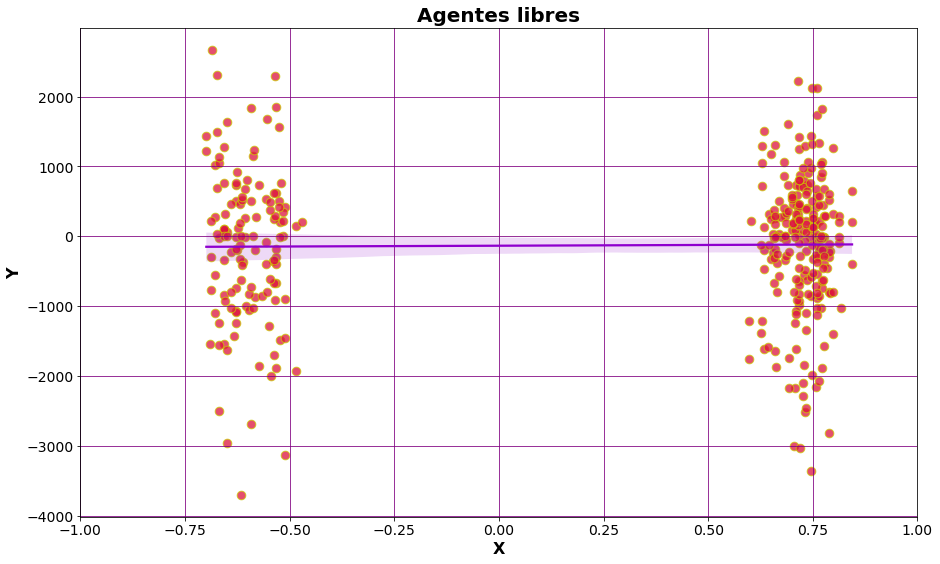

In [112]:
sns.regplot(x = 'X', y = 'Y', data = df_article_regression,
            scatter_kws={"color": '#DC143C', 'edgecolor':'#CCCC00', "s":75, "alpha":0.75},
            line_kws={"color": "#8e00ce"})
plt.title("Agentes libres", fontsize = 20, fontweight = 'bold')
plt.xlabel("X", fontsize = 16, fontweight = 'bold')
plt.ylabel("Y", fontsize = 16, fontweight = 'bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-1,1)
plt.grid(color='purple', linestyle='-')
plt.show()

Esto aún no nos dice la significancia estadística del modelo de itnerés puesto que no consideraremos en este script las variables instrumentales.

### Modelo

Regresemos $Y$ sobre $X$.

In [113]:
Y = df_article_regression['Y'].tolist()
X = df_article_regression['X'].tolist()

X = sm.add_constant(X)

free_agent_model = sm.OLS(Y, X).fit()

In [114]:
free_agent_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.06928
Date:                Thu, 21 Jul 2022   Prob (F-statistic):              0.793
Time:                        10:28:31   Log-Likelihood:                -3026.3
No. Observations:                 363   AIC:                             6057.
Df Residuals:                     361   BIC:                             6064.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -134.0495     57.258     -2.341      0.020    -246.651     -21.448
x1            21.9785     83.504      0.263      0.793    -142.236     186.193
==============================================================================
Omnibus:                       22.001   Durbin-Watson:                   2.388
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.164
Skew:                          -0.514   Prob(JB):                     1.26e-06
Kurtosis:                       3.859   Cond. No.                         1.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""